# Importing Necessary libraries

In [7]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error


# load data

In [8]:
train_data=pd.read_csv('C:\\Users\\akhil\\Downloads\\ML projects\\Hazard_train.csv')
test_data=pd.read_csv('C:\\Users\\akhil\\Downloads\\ML projects\\Hazard_test_share.csv')

In [9]:
# Add a 'data' column to distinguish train and test sets
train_data['data'] = 'train'
test_data['data'] = 'test'

In [10]:
# Combine train and test data for preprocessing
all_data = pd.concat([train_data, test_data], axis=0, sort=False)

In [11]:
# Verify the 'data' column exists
if 'data' not in all_data.columns:
    raise KeyError("'data' column is missing! Ensure it was added to train and test sets.")

In [12]:
# Encode categorical variables
cat_cols = all_data.select_dtypes(['object']).columns

In [13]:
## Preserve the 'data' column to avoid dropping it during encoding
if 'data' not in cat_cols:
    cat_cols = cat_cols.append(pd.Index(['data']))

for col in cat_cols:
    k = all_data[col].value_counts()
    cats = k[k >= 100].index  # Keep categories with sufficient occurrences

    for cat in cats:
        name = f"{col}_{cat}"
        all_data[name] = (all_data[col] == cat).astype(int)


In [14]:
# Drop original categorical columns after encoding, except for 'data'
all_data.drop(columns=[col for col in cat_cols if col != 'data'], inplace=True, errors='ignore')

In [15]:
# Debugging to check if 'data' column is intact
if 'data' not in all_data.columns:
    raise KeyError("'data' column is missing after preprocessing! Check encoding steps.")


In [16]:
# Split back into train and test based on the 'data' column
x_train = all_data[all_data['data'] == 'train'].drop(['Id', 'Hazard', 'data'], axis=1, errors='ignore')
y_train = all_data[all_data['data'] == 'train']['Hazard']
x_test = all_data[all_data['data'] == 'test'].drop(['Id', 'Hazard', 'data'], axis=1, errors='ignore')

In [17]:
# Debugging shapes of datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")


x_train shape: (40799, 109)
y_train shape: (40799,)
x_test shape: (10200, 109)


In [18]:
# Check for empty datasets
if x_train.empty or y_train.empty:
    raise ValueError("x_train or y_train is empty. Check preprocessing steps!")

In [19]:
# Split training data for validation
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [20]:
# Debugging train-test split sizes
print(f"Train set size: {X_train.shape[0]}, Validation set size: {X_val.shape[0]}")


Train set size: 32639, Validation set size: 8160


In [21]:
# Model: HistGradientBoostingRegressor
model=HistGradientBoostingRegressor(loss='poisson',)

In [22]:
# Hyperparammeter tuning
param_grid={
    'max_iter':[100,200,300],
    'max_depth':[3,5,7],
    'learning_rate':[0.01,0.1,0.2]
}
grid_search=GridSearchCV(model,param_grid,scoring='neg_mean_absolute_error',cv=5,n_jobs=1,verbose=2)
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.7s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.5s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.6s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.5s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   0.5s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.9s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.7s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.7s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.7s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   0.7s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=300; total time=   1.0s
[CV] END ......learning_rate=0.01, max_depth=3,

GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(loss='poisson'),
             n_jobs=1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'max_iter': [100, 200, 300]},
             scoring='neg_mean_absolute_error', verbose=2)

In [23]:
# Best model
best_model = grid_search.best_estimator_

In [24]:
# Validation performance
val_preds = best_model.predict(X_val)
mae = mean_absolute_error(Y_val, val_preds)
print(f"Validation MAE: {mae}")

Validation MAE: 2.6286463068324135


In [25]:
# Predict on test data
test_preds = best_model.predict(x_test)

In [26]:
# Save submission
submission = pd.DataFrame({'Hazard': test_preds})
submission.to_csv("Hazard_submission_v1.csv", index=False)

print("Submission file saved as Hazard_submission_v1.csv")


Submission file saved as Hazard_submission_v1.csv


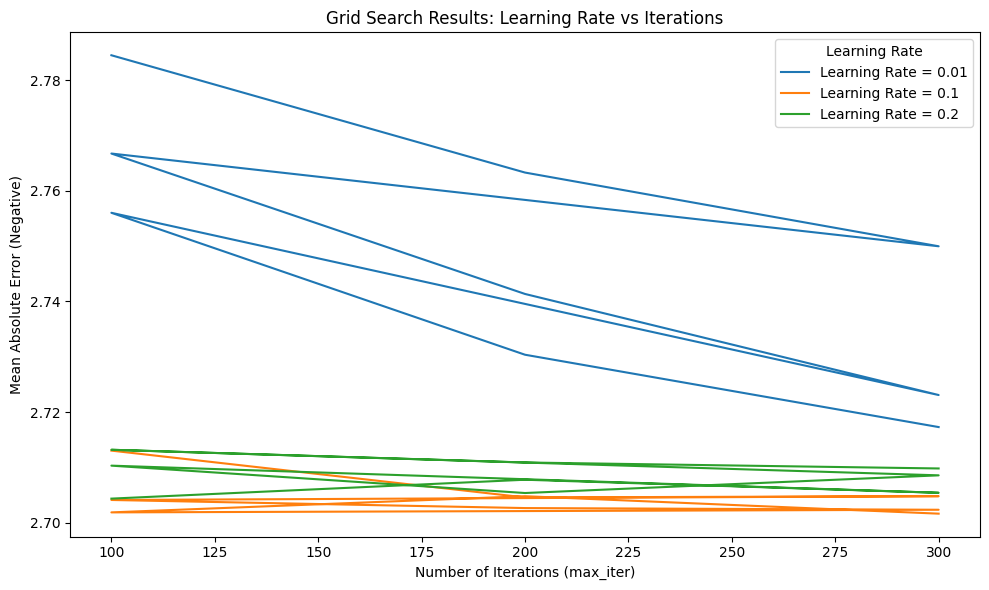

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Extract results from GridSearchCV
results = grid_search.cv_results_

# Visualization of Grid Search Results
plt.figure(figsize=(10, 6))
for learning_rate in param_grid['learning_rate']:
    # Filter rows where 'param_learning_rate' matches the current learning rate
    subset = results['param_learning_rate'] == learning_rate
    x_values = np.array(results['param_max_iter'])[subset]  # max_iter values
    y_values = -1 * np.array(results['mean_test_score'])[subset]  # mean_test_score values

    # Plot for this learning rate
    plt.plot(x_values, y_values, label=f"Learning Rate = {learning_rate}")

plt.xlabel("Number of Iterations (max_iter)")
plt.ylabel("Mean Absolute Error (Negative)")
plt.title("Grid Search Results: Learning Rate vs Iterations")
plt.legend(title="Learning Rate")
plt.tight_layout()
plt.show()
